# Train a ML model for trait retrieval 
Based on simulated spectra from RTMs

In [1]:
import sys
import os
from pathlib import Path
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent

## 1. Get data
Load LUT tables in a dataframe and split into train and test (70/30 split)

In [5]:
safe_dir = base_dir.joinpath(Path('results/lut_based_inversion/eschikon'))

In [4]:
df = pd.DataFrame()

for scene_dir in safe_dir.glob('*.SAFE'):
  # Load LUT into dataframe
  with open(scene_dir.joinpath('all_phases_lai-cab-ccc-car_lut.pkl'), 'rb') as f:
    df = pd.concat([df, pickle.load(f)])

In [5]:
df.drop(columns=['n', 'cab', 'car', 'ant', 'cbrown', 'cw', 'cm', 'lidfa', 'hspot',
       'rsoil', 'psoil', 'lidfb', 'tts', 'tto', 'psi', 'typelidf', 'ccc'], inplace=True)

In [6]:
# Splitting the DataFrame into features (X) and target variable (y)
X = df.drop('lai', axis=1)
y = df['lai']

# Splitting the data into 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
print('Training size', len(X_train))
print('Test size', len(X_test))

Training size 1565095
Test size 670756


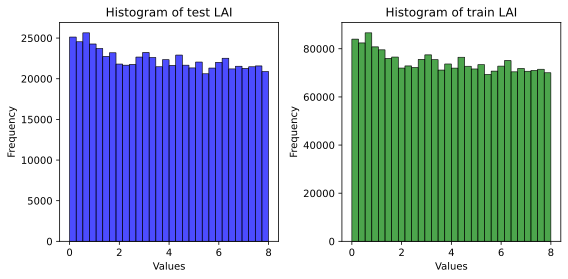

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plotting the histogram for y_test
sns.histplot(y_test, bins=30, color='blue', alpha=0.7, ax=axs[0])
axs[0].set_title('Histogram of test LAI')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')

# Plotting the histogram for y
sns.histplot(y, bins=30, color='green', alpha=0.7, ax=axs[1])
axs[1].set_title('Histogram of train LAI')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')

# Adjust layout for better presentation
plt.tight_layout()
plt.show()

## 2. Set up model: Random Forest

In [58]:
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor.fit(X_train, y_train)

y_pred = random_forest_regressor.predict(X_test)

# Evaluate the performance of the model (for example, using Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


Mean Squared Error: 0.35
Root Mean Squared Error: 0.59


In [22]:
# Save model

model_filename = 'random_forest_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(random_forest_regressor, model_file)

"""
with open(model_filename, 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)
"""

### Analyse residuals and perfromance

In [2]:
# Save model

model_filename = 'random_forest_model.pkl'
with open(model_filename, 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)

In [3]:
y_pred = loaded_rf_model.predict(X_test)

NameError: name 'X_test' is not defined

In [15]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.savefig('residuals.png')

In [21]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.savefig('actual_vs_predicted.png')

## 3. Inference: get LAI of (new) images

In [2]:
# Try on SwissFutureFarm

safe_test_dir = base_dir.joinpath(Path('results/lut_based_inversion/SwissFutureFarm'))

df = pd.DataFrame()
for scene_dir in safe_test_dir.glob('*.SAFE'):
  # Load LUT into dataframe
  with open(scene_dir.joinpath('all_phases_lai-cab-ccc-car_lut.pkl'), 'rb') as f:
    df = pd.concat([df, pickle.load(f)])

df.drop(columns=['n', 'cab', 'car', 'ant', 'cbrown', 'cw', 'cm', 'lidfa', 'hspot',
       'rsoil', 'psoil', 'lidfb', 'tts', 'tto', 'psi', 'typelidf', 'ccc'], inplace=True)
       
# Splitting the DataFrame into features (X) and target variable (y)
X = df.drop('lai', axis=1)
y = df['lai']

In [3]:
model_filename = 'random_forest_model.pkl'
with open(model_filename, 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)

In [4]:
# Make predictions on the new data
predictions = loaded_rf_model.predict(X)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (out of domain test set): {mse:.2f}')
print(f"Root Mean Squared Error (out of domain test set): {rmse:.2f}")

Mean Squared Error (out of domain test set): 0.22
Root Mean Squared Error (out of domain test set): 0.47


In [6]:
y_pred = loaded_rf_model.predict(X)
residuals = y - y_pred
plt.scatter(y, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.savefig('residuals_ood.png')

### Test performance in different growth phases (SwissFutureFarm)

In [5]:
# Germination - End of tillering

safe_test_dir = base_dir.joinpath(Path('results/lut_based_inversion/SwissFutureFarm'))

df = pd.DataFrame()
for scene_dir in safe_test_dir.glob('*.SAFE'):
  # Load LUT into dataframe
  with open(scene_dir.joinpath('germination-endoftillering_lai-cab-ccc-car_lut_no-constraints.pkl'), 'rb') as f:
    df = pd.concat([df, pickle.load(f)])

df.drop(columns=['n', 'cab', 'car', 'ant', 'cbrown', 'cw', 'cm', 'lidfa', 'hspot',
       'rsoil', 'psoil', 'lidfb', 'tts', 'tto', 'psi', 'typelidf', 'ccc'], inplace=True)
       
# Splitting the DataFrame into features (X) and target variable (y)
X = df.drop('lai', axis=1)
y = df['lai']

# Make predictions on the new data
predictions = loaded_rf_model.predict(X)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (out of domain test set): {mse:.2f}')
print(f"Root Mean Squared Error (out of domain test set): {rmse:.2f}")

Mean Squared Error (out of domain test set): 0.07
Root Mean Squared Error (out of domain test set): 0.27


In [6]:
# Stem elongation - End of heading

safe_test_dir = base_dir.joinpath(Path('results/lut_based_inversion/SwissFutureFarm'))

df = pd.DataFrame()
for scene_dir in safe_test_dir.glob('*.SAFE'):
  # Load LUT into dataframe
  with open(scene_dir.joinpath('stemelongation-endofheading_lai-cab-ccc-car_lut_no-constraints.pkl'), 'rb') as f:
    df = pd.concat([df, pickle.load(f)])

df.drop(columns=['n', 'cab', 'car', 'ant', 'cbrown', 'cw', 'cm', 'lidfa', 'hspot',
       'rsoil', 'psoil', 'lidfb', 'tts', 'tto', 'psi', 'typelidf', 'ccc'], inplace=True)
       
# Splitting the DataFrame into features (X) and target variable (y)
X = df.drop('lai', axis=1)
y = df['lai']

# Make predictions on the new data
predictions = loaded_rf_model.predict(X)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (out of domain test set): {mse:.2f}')
print(f"Root Mean Squared Error (out of domain test set): {rmse:.2f}")

Mean Squared Error (out of domain test set): 1.91
Root Mean Squared Error (out of domain test set): 1.38


## 4. Improve model
- Standardise input data ( we actually dont need to normalise for RF models)
- K-fold cross validation
- Hyperparameter tuning

analyse how many min traning data

In [12]:
# K-fold cross validation

random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # You can adjust the number of splits
cv_results = cross_val_score(random_forest_regressor, X, y, cv=kfold, scoring='neg_mean_squared_error')

# Convert negative mean squared error to positive root mean squared error
rmse_scores = np.sqrt(-cv_results)

# Print the results
print("Cross-Validation Results:")
print(f"Root Mean Squared Error for each fold: {rmse_scores}")
print(f"Mean Root Mean Squared Error: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")


Cross-Validation Results:
Root Mean Squared Error for each fold: [0.56672206 0.5647419  0.56658124 0.56778057 0.56784404]
Mean Root Mean Squared Error: 0.57 (+/- 0.00)


In [13]:
# Save model

model_filename = 'random_forest_model_kfold.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(random_forest_regressor, model_file)

"""
with open(model_filename, 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)
"""

"\nwith open(model_filename, 'rb') as model_file:\n    loaded_rf_model = pickle.load(model_file)\n"

In [17]:
# Adding data standardisation -> careful about the interpretation of the results (LAI)

random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
model = make_pipeline(StandardScaler(), random_forest_regressor) # standard scaler assumes gaussian variables. Might need min-max if not the case
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # You can adjust the number of splits
cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_results)

# Print the results
print("Cross-Validation Results:")
print(f"Root Mean Squared Error for each fold: {rmse_scores}")
print(f"Mean Root Mean Squared Error: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")

Cross-Validation Results:
Root Mean Squared Error for each fold: [0.56703974 0.56477033 0.56669391 0.56776578 0.5680809 ]
Mean Root Mean Squared Error: 0.57 (+/- 0.00)


In [18]:
# Save model

model_filename = 'random_forest_model_norm.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(random_forest_regressor, model_file)

"""
with open(model_filename, 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)
"""

"\nwith open(model_filename, 'rb') as model_file:\n    loaded_rf_model = pickle.load(model_file)\n"

In [10]:
# Performance in function of the train size

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables
min_train_size = 10  # Minimum number of training data points
max_train_size = len(X_train)  # Maximum number of training data points
step_size = 10  #

# Lists to store results
train_sizes = [10000, 100000, 500000, 1000000]
mean_rmse_scores = []

# Iterate over different training sizes
for train_size in train_sizes:
  # Select a subset of the training data
    X_train_subset = X_train[:train_size]
    y_train_subset = y_train[:train_size]

    # Create a new RandomForestRegressor for each iteration
    random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # Perform k-fold cross-validation
    cv_results = cross_val_score(random_forest_regressor, X_train_subset, y_train_subset, cv=kfold, scoring='neg_mean_squared_error')

    # Convert negative mean squared error to positive root mean squared error
    rmse_scores = np.sqrt(-cv_results)

    # Store results
    train_sizes.append(train_size)
    mean_rmse_scores.append(rmse_scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, mean_rmse_scores, marker='o')
plt.title('RMSE vs Training Size')
plt.xlabel('Training Size')
plt.ylabel('Mean RMSE')
plt.grid(True)
plt.show()

KeyboardInterrupt: 